In [4]:
%matplotlib inline

import os
from cs236781.answers import display_answer
import hw3.answers

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
import torchdata
import unittest


test = unittest.TestCase()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
EMB_SIZE = 512
DIM = 512
HEADS = 8
NUM_LAYERS = 3
BATCH_SIZE = 2048
EPOCHS = 20

ImportError: cannot import name 'multi30k' from 'torchtext.datasets' (C:\Users\HAGIL\miniconda3\envs\cs236781-hw3\lib\site-packages\torchtext\datasets\__init__.py)

$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Language Translation with nn.Transformer and torchtext
<a id=part3></a>


This part shows:
*   How to train a translation model from scratch using Transformer. 
*   Use tochtext library to access [Multi30k](https://www.statmt.org/wmt16/multimodal-task.html#task1) dataset in order to train a German to English translation model.




Data Sourcing and Processing
----------------------------

[Torchtext library](https://pytorch.org/text/stable/) has utilities for creating datasets that can be easily
iterated through for the purposes of creating a language translation
model. In this example, we show how to use torchtext's inbuilt datasets, 
tokenize a raw text sentence, build vocabulary, and numericalize tokens into tensor. We will use
[Multi30k dataset from torchtext library](https://pytorch.org/text/stable/datasets.html#multi30k) 
that yields a pair of source-target raw sentences. 





### Building the Vocabulary
Let's begin by building a vocabulary of tokens using an external tokenizer for english and german.



In [27]:
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'
language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

# Place-holders
token_transform = {}
vocab_transform = {}

# Create source and target language tokenizer. 
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
    
# helper function to yield list of tokens
def yield_tokens(data_iter, language):
    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])


# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']


for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator 
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)
    # Set UNK_IDX as the default index. This index is returned when the token is not found. 
    # If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
    vocab_transform[ln].set_default_index(UNK_IDX)

Please install SpaCy. See the docs at https://spacy.io for more information.


ModuleNotFoundError: No module named 'spacy'

In [24]:
stoi_mapping = vocab_transform[SRC_LANGUAGE].get_stoi()
print (f"Size of src vocab: {len(vocab_transform[SRC_LANGUAGE])}")
print (f"Size of tgt vocab: {len(vocab_transform[TGT_LANGUAGE])}")
print (f"Index for src padding: {stoi_mapping[special_symbols[1]]}")
print (f"Index for start of sequence token: {stoi_mapping[special_symbols[2]]}")
print (f"Index for end of sequence token: {stoi_mapping[special_symbols[3]]}")
print(f"An example of tokenization into words of a sentence in the src language: {token_transform[SRC_LANGUAGE]('Eine Gruppe von Menschen steht vor einem Iglu .')}")
print(f"An example of tokenization into vocab indices of a sentence in the src language: {vocab_transform[SRC_LANGUAGE](token_transform[SRC_LANGUAGE]('Eine Gruppe von Menschen steht vor einem Iglu .'))}")

KeyError: 'de'

### Question 1
Which tokenization are we using? Word tokenization, character tokenization, or subword tokenization (for example - [BPE](https://en.wikipedia.org/wiki/Byte_pair_encoding)).

Explain the drawbacks of the tokenization method we are using compared to others.


In [4]:
display_answer(hw3.answers.part3_q1)


**Your answer:**




Seq2Seq Network using Transformer
---------------------------------

Transformer is a Seq2Seq model introduced in [“Attention is all you
need”](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
paper for solving machine translation tasks. 
We will create a Seq2Seq network that uses Transformer to translate sentences from german to english. The architecture of the transformer is described in the image below:


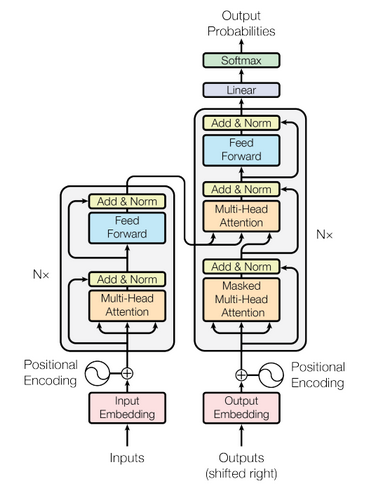




### Input Embedding and Positional Encoding
The first part is the embedding layer. This layer converts tensor of input indices into corresponding tensor of input embeddings. These embedding are further augmented with positional encodings to provide position information of input tokens to the model.

**TODO**:
- Implement the `PositionalEncoder` class in the `hw3/transformer.py` module.
- Run the following block.

In [5]:
from hw3.transformer import  PositionalEncoder

positionalEncoder = PositionalEncoder(EMB_SIZE)

### Multi-Head Attention
Once we have our embedded values (with positional encodings), we can start building the layers of our model.

Here is an overview of the multi-headed attention layer:

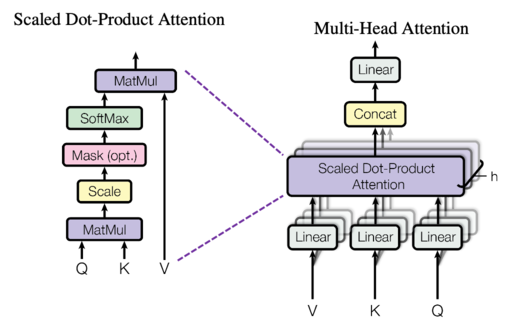

V, K and Q stand for ‘key’, ‘value’ and ‘query’. These are terms used in attention function. In the case of self attention, V, K and Q will simply be identical copies of the embedding vector (plus positional encoding). They will have the dimensions Batch_size * seq_len * dim.

In multi-head attention we split the embedding vector into N heads, so they will then have the dimensions batch_size * N * seq_len * (dim / N).

**TODO**:
- Implement the method `forward` of `MultiHeadAttention` class in the `hw3/transformer.py` module. Use the given function `attention` in `hw3/transformer.py`.
- Run the following block.

In [6]:
from hw3.transformer import MultiHeadAttention

multiHeadAttention = MultiHeadAttention(HEADS, DIM)

### Mask
During training, we need a subsequent word mask that will prevent model to look into
the future words when making predictions. We will also need masks to hide
source and target padding tokens. Let's define a function that will take care of both. 

In the encoder and decoder: The mask will zero attention outputs wherever there is just padding in the input sentences.
In the decoder: To prevent the decoder ‘peaking’ ahead at the rest of the translated sentence when predicting the next word.

**TODO**:
- Implement the function `get_subsequent_mask` in the `hw3/transformer.py` module. 


In [7]:
from hw3.transformer import get_pad_mask, get_subsequent_mask

### Encoder and Decoder Layers
Let’s have another look at the over-all architecture and start building:

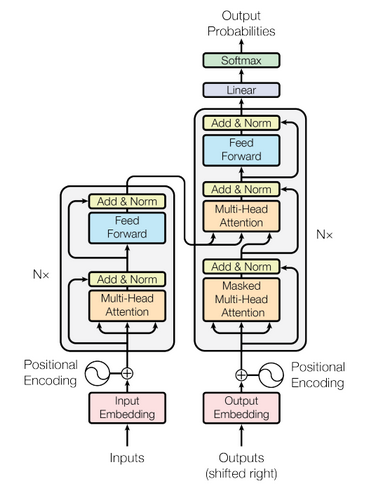

If you look at the diagram closely you can see a ‘Nx’ next to the encoder and decoder architectures. In reality, the encoder and decoder in the diagram above represent one layer of an encoder and one of the decoder. N is the variable for the number of layers there will be.
We will now build a DecoderLayer modules with the architecture shown in the model above.


**TODO**:
- Implement the method `forward` of `DecoderLayer` class in the `hw3/transformer.py` module, similar to the class `EncoderLayer`. Use the given classes: `Norm` and `FeedForward` in `hw3/transformer.py`.
- Run the following block.


In [8]:
from hw3.transformer import DecoderLayer, EncoderLayer

encoderLayer = EncoderLayer(DIM, HEADS)
decoderLayer = DecoderLayer(DIM, HEADS)

**TODO**:
- In a similar way, Implement the `Decoder` class in the `hw3/transformer.py` module.
- Run the following block.


In [9]:
from hw3.transformer import Decoder, Encoder

encoder = Encoder(len(vocab_transform[SRC_LANGUAGE]), DIM, NUM_LAYERS, HEADS, PAD_IDX)
decoder = Decoder(len(vocab_transform[TGT_LANGUAGE]), DIM, NUM_LAYERS, HEADS, PAD_IDX)

### Transfomer
Now we can finish the implementation of the Transformer.

**TODO**:
- Implement the method `forward` of `Transformer` class in the `hw3/transformer.py` module.
- Run the following block.


In [10]:
from hw3.transformer import Transformer

model = Transformer(len(vocab_transform[SRC_LANGUAGE]), len(vocab_transform[TGT_LANGUAGE]), DIM, NUM_LAYERS, HEADS, PAD_IDX)

Training the Model
---------------------------------


### Warm up
The learning rate warmup is an approach that uses a relatively small step size at the beginning of the training. The learning rate is increased linearly or non-linearly to a specific value in the first few epochs, and then shrinks to zero.

**TODO**:
- Implement the method `_get_lr_scale` of `ScheduledOptim` class in the `hw3/Optim.py` module.
- Run the following block.


### Train
With the transformer built, all that remains is to train it on the Multi30k dataset:


In [11]:
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from hw3.Optim import ScheduledOptim
from hw3.transformerUtils import sequential_transforms, tensor_transform, train


text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor
# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

transformer = Transformer(
len(vocab_transform[SRC_LANGUAGE]), len(vocab_transform[TGT_LANGUAGE]), DIM, NUM_LAYERS, HEADS, PAD_IDX).to(DEVICE)

optimizer = ScheduledOptim(
optim.Adam(transformer.parameters(), betas=(0.9, 0.98), eps=1e-09),
2.0, DIM, 4000)

train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
validation_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
valid_dataloader = DataLoader(validation_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

train(transformer, train_dataloader, valid_dataloader, optimizer, DEVICE, EPOCHS)

[Info] Training performance will be written to file: logs\train.log and logs\valid.log
[ Epoch 0 ]


                                          
KeyboardInterrupt



Testing the Model
---------------------------------

With the transformer built, all that remains is to train it on the Multi30k dataset. 


Questions
---------------------------------

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

### Question 2

How many parameters your transformer has? how many if you exclude the embedings?
Assume we have two tensors `X` and `Y` of shape `b,n,m` and `b,m,p`

In [ ]:
display_answer(hw3.answers.part3_q2)

### Question 3

How can we use the architecture we built to translate documents efficiently memory-wise?

In [ ]:
display_answer(hw3.answers.part3_q3)

### Question 4

what is the diffrance between using `torch.bmm(X,Y)` and `torch.matmul(X,Y)`?

In [ ]:
display_answer(hw3.answers.part3_q4)